In [1]:
import numpy as np
import torch
from torch import nn
from tropical import to_tensor, Tropical, TropicalMonomial, TropicalPolynomial, PolyNet, DiffPolyNet, convert_net_to_tropical

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import JuPyMake
JuPyMake.InitializePolymake()
JuPyMake.ExecuteCommand("application 'tropical';")

(True, '', '', '')

In [4]:
%load_ext autoreload
%autoreload 2

# Создаем сеть 2-18-2 со случайными весами

In [5]:
inp_size = [2,10]
out_size = [10,2]

# A = [np.random.randint(-10, 10, size=inp_size[i]*out_size[i]).reshape(out_size[i],inp_size[i]) for i in range(len(inp_size))]

# b = [np.random.randn(out_size[i]) for i in range(len(A))]

In [6]:
class Net(torch.nn.Module):
    def __init__(self, inp_size, out_size, bias=True):
        super(Net, self).__init__()
        
        self.linears = nn.ModuleList([nn.Linear(inp_size[0], out_size[0], bias=bias)])
        
        for i in range(1, len(inp_size)):
            self.linears.extend([nn.Linear(inp_size[i], out_size[i], bias=bias)])
                
#         for i in range(len(inp_size)):
#             self.linears[i].weight.data.copy_(to_tensor(A[i]))
#             self.linears[i].bias.data.copy_(to_tensor(b[i]))
    def forward(self, output):
        for i, l in enumerate(self.linears):
            output = l.forward(output)
            if i<len(self.linears)-1:
                output = torch.relu(output)
        return output

# Создадим стандартную классификационную задачу

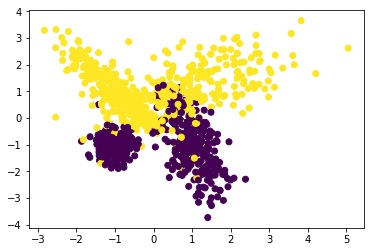

In [7]:
from sklearn.datasets import make_classification, make_moons, make_gaussian_quantiles

X, Y = make_classification(n_samples=1000,n_features=2, n_redundant=0,
                           n_informative=2, n_clusters_per_class=2,
                           n_classes=2, random_state=5)
# X, Y = make_moons(n_samples=1000, noise=0.1, random_state=0)

plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y)   
x_t = torch.from_numpy(X).float()
y_t = torch.from_numpy(Y).long()

In [8]:
model = Net(inp_size,out_size,bias=True)

epochs = 1000
batch_size = 100
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

dataset = torch.utils.data.TensorDataset(x_t, y_t)

loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)


for epoch in range(epochs):
    loss_epoch = 0
    for x, y in loader:
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        loss_epoch += loss.item()
        
        opt.step()
        opt.zero_grad()
    
    if epoch%100 == 0:
        with torch.no_grad():
            acc = (model.forward(x_t).argmax(1)==y_t.flatten()).float().mean()
        print('Epoch: ', epoch, ' loss: ', loss_epoch, 'acc: ', acc)
        

    



Epoch:  0  loss:  6.768862962722778 acc:  tensor(0.5050)
Epoch:  100  loss:  2.3597713261842728 acc:  tensor(0.9180)
Epoch:  200  loss:  2.0102199614048004 acc:  tensor(0.9290)
Epoch:  300  loss:  1.802562639117241 acc:  tensor(0.9300)
Epoch:  400  loss:  1.753233090043068 acc:  tensor(0.9290)
Epoch:  500  loss:  1.7309517189860344 acc:  tensor(0.9330)
Epoch:  600  loss:  1.719679482281208 acc:  tensor(0.9330)
Epoch:  700  loss:  1.7119382694363594 acc:  tensor(0.9360)
Epoch:  800  loss:  1.7058451920747757 acc:  tensor(0.9360)
Epoch:  900  loss:  1.7017170265316963 acc:  tensor(0.9360)


# Квантизуем веса сети

In [9]:
M = 10

model.linears[0].weight.data.copy_((model.linears[0].weight*M).int())
model.linears[1].weight.data.copy_((model.linears[1].weight*M).int())

model.linears[0].bias.data.copy_((model.linears[0].bias*M).int())
model.linears[1].bias.data.copy_((model.linears[1].bias*M).int())

print('New acc: ', (model.forward(x).argmax(1)==y.flatten()).float().mean())

New acc:  tensor(0.9300)


In [10]:
model.linears[0].weight.data,model.linears[1].weight.data

(tensor([[ -1.,  14.],
         [  4.,  -2.],
         [  0., -15.],
         [ 11.,   4.],
         [ 10.,   7.],
         [  9.,  -6.],
         [-11.,  -6.],
         [  1.,   8.],
         [ 18.,   9.],
         [ -6., -10.]]),
 tensor([[-10.,   1.,   9., -25., -18.,  -6.,   3.,  -7.,  16.,   8.],
         [  9.,  -1.,  -5.,  24.,  12.,   8.,  -2.,   5., -15.,  -3.]]))

# Конвертим в разницу полиномов

In [11]:
h,g = convert_net_to_tropical(model)

In [12]:
h[0]

a^81⨀b^100 ⨁ -16.0⨀a^33⨀b^20 ⨁ -6.0⨀a^52⨀b^80 ⨁ 68.0⨀a^336⨀b^361 ⨁ 52.0⨀a^288⨀b^281 ⨁ 86.0⨀a^373⨀b^242 ⨁ 70.0⨀a^325⨀b^162 ⨁ -12.0⨀a^48⨀b^82 ⨁ -28.0⨀b^2 ⨁ 6.0⨀a^85⨀b^233 ⨁ -10.0⨀a^37⨀b^153 ⨁ 74.0⨀a^340⨀b^224 ⨁ 58.0⨀a^292⨀b^144 ⨁ 80.0⨀a^369⨀b^244 ⨁ 64.0⨀a^321⨀b^164 ⨁ -22.0⨀a^4 ⨁ -6.0⨀a^52⨀b^215 ⨁ -22.0⨀a^4⨀b^135 ⨁ a^81⨀b^235 ⨁ -16.0⨀a^33⨀b^155 ⨁ 68.0⨀a^336⨀b^226 ⨁ 52.0⨀a^288⨀b^146 ⨁ -12.0⨀a^48⨀b^217 ⨁ -28.0⨀b^137 ⨁ 86.0⨀a^373⨀b^377 ⨁ 70.0⨀a^325⨀b^297 ⨁ -10.0⨀a^37⨀b^18 ⨁ 6.0⨀a^85⨀b^98 ⨁ 74.0⨀a^340⨀b^359 ⨁ 58.0⨀a^292⨀b^279 ⨁ 80.0⨀a^369⨀b^379 ⨁ 64.0⨀a^321⨀b^299

In [13]:
g[0]

-116.0⨀a^251⨀b^501 ⨁ -316.0⨀a^526⨀b^601 ⨁ -43.0⨀a^312⨀b^521 ⨁ -243.0⨀a^587⨀b^621 ⨁ 149.0⨀a^78⨀b^431 ⨁ -51.0⨀a^353⨀b^531 ⨁ -216.0⨀a^261⨀b^361 ⨁ -416.0⨀a^536⨀b^461 ⨁ -143.0⨀a^322⨀b^381 ⨁ -343.0⨀a^597⨀b^481 ⨁ 49.0⨀a^88⨀b^291 ⨁ -151.0⨀a^363⨀b^391 ⨁ -192.0⨀a^315⨀b^325 ⨁ -392.0⨀a^590⨀b^425 ⨁ a^81⨀b^235 ⨁ -200.0⨀a^356⨀b^335 ⨁ 73.0⨀a^142⨀b^255 ⨁ -127.0⨀a^417⨀b^355 ⨁ -92.0⨀a^305⨀b^465 ⨁ -292.0⨀a^580⨀b^565 ⨁ 100.0⨀a^71⨀b^375 ⨁ -100.0⨀a^346⨀b^475 ⨁ 173.0⨀a^132⨀b^395 ⨁ -27.0⨀a^407⨀b^495 ⨁ -167.0⨀a^268⨀b^417 ⨁ -367.0⨀a^543⨀b^517 ⨁ -67.0⨀a^258⨀b^557 ⨁ -267.0⨀a^533⨀b^657 ⨁ 124.0⨀a^125⨀b^339 ⨁ -76.0⨀a^400⨀b^439 ⨁ 24.0⨀a^135⨀b^199 ⨁ -176.0⨀a^410⨀b^299

# Полигоны Ньютона и subdivision для каждого из полиномов разницы по первой координате

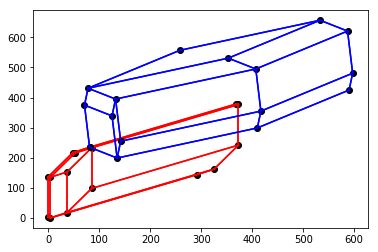

In [14]:
h[0].plot_dual_sub(color='red',name='b')

g[0].plot_dual_sub(color='blue',name='b')

# Полигоны Ньютона и subdivision для каждого из полиномов разницы по второй координате

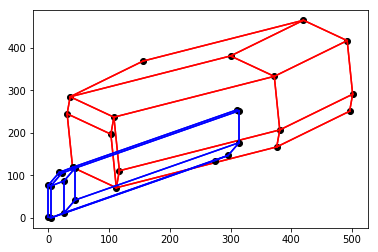

In [15]:
h[1].plot_dual_sub(color='red',name='b')

g[1].plot_dual_sub(color='blue',name='b')

# Минимизируем полиномы

In [16]:
h0_min = h[0].minimize()
h1_min = h[1].minimize()
g0_min = g[0].minimize()
g1_min = g[1].minimize()

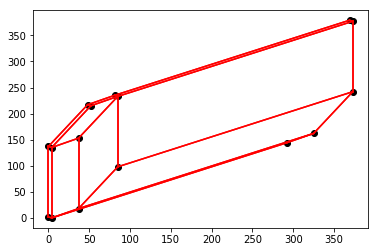

In [17]:
h0_min.plot_dual_sub(color='red',name='b')

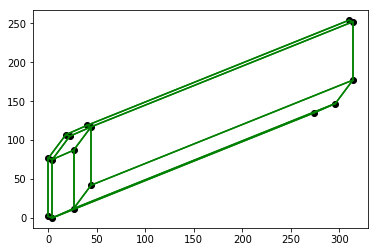

In [18]:
g1_min.plot_dual_sub(color='green',name='b')

Видно, что противоположные полиномы очень похожи

# Составляем полином из статьи

In [19]:
h0g1_min = (h0_min*g1_min).minimize()

In [20]:
h1g0_min = (h1_min*g0_min).minimize()

In [21]:
R = h0g1_min + h1g0_min

In [23]:
R_min = R.minimize()

# Полигоны Ньютона и subdivision для нового полинома и двух его слагаемых

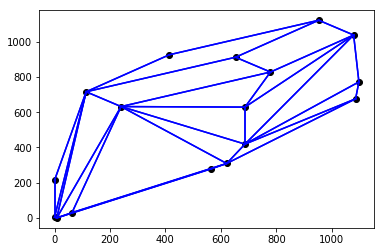

In [24]:
R_min.plot_dual_sub(color='blue',name='b')

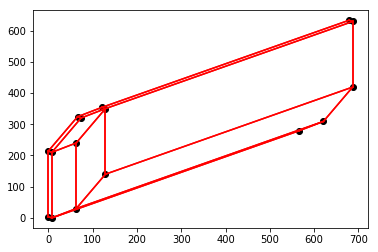

In [25]:
h0g1_min.plot_dual_sub(color='red',name='b')

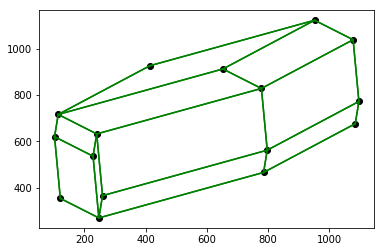

In [26]:
h1g0_min.plot_dual_sub(color='green',name='b')

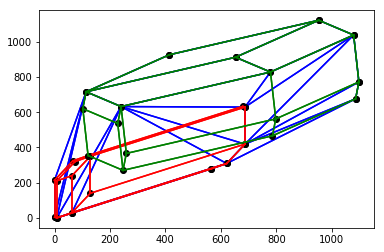

In [27]:
R_min.plot_dual_sub(color='blue',name='b')
h0g1_min.plot_dual_sub(color='red',name='b')
h1g0_min.plot_dual_sub(color='green',name='b')

Полином, который получали ребята из kausta

In [28]:
import sys
sys.path.append('TG-DNN/Playground/')

from Libraries import *
from Geometry_Plottings import *
from Geometry_utilities import *
from trainings import *

In [29]:
new_model = Net(10,2,2,True).to('cpu')

In [30]:
new_model

Net(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (relu): ReLU()
)

In [31]:
new_model.fc1.weight.data.copy_(model.linears[0].weight)
new_model.fc2.weight.data.copy_(model.linears[1].weight)

new_model.fc1.bias.data.copy_(model.linears[0].bias)
new_model.fc2.bias.data.copy_(model.linears[1].bias)

tensor([0., 3.], grad_fn=<CopyBackwards>)

In [32]:
boundary_vertices1,decision_boundary1 = get_model_polytopes(new_model,True,True,False) #True for getting the boundary polytope

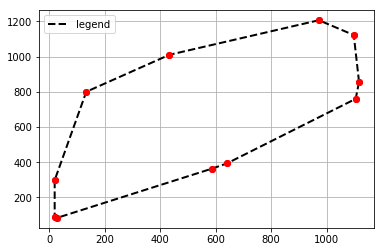

In [33]:
plot_polytope(boundary_vertices1,decision_boundary1)

# Рисуем реальную decision boundary исходной нейронки

In [34]:
def plot_decision_boundary(pred_func):
    xx,yy = np.meshgrid(np.arange(-5, 5, 0.001), np.arange(-5, 5, 0.001))
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y, alpha=0.1)   

In [37]:
def predict(x):
    x = torch.from_numpy(x).type(torch.FloatTensor)
    ans = model.forward(x)
    return ans.argmax(1).float().detach().numpy()

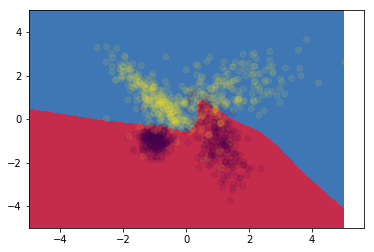

In [38]:
plot_decision_boundary(lambda x : predict(x))

# Видно, что decision boundary перпендикулярны тем границам полигона Нюьтона, которые не покрыты полигонами слагаемых.

In [39]:
pred = model.forward(x_t).argmax(1)

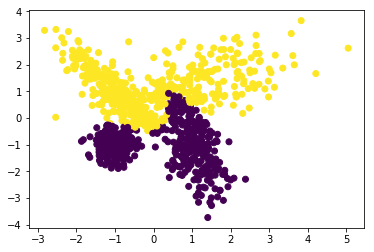

In [41]:
plt.scatter(X[:, 0], X[:, 1], marker='o', c=pred.detach().numpy().flatten())   